In [1]:
from web3 import Web3
from dotenv import load_dotenv
import pandas as pd
import os
import json

load_dotenv() 

ALCHEMY_API_KEY = os.getenv("ALCHEMY_API_KEY")

sushi_pool = "0x73DF54500E52343516C0110B4863afaD77423B9C"
univ3_10000 = "0xcDb3a8ade333fB408dB9dCF4326C70b1c3229bB5"
univ3_3000 = "0xFC711972e37f62DC82406b5FF98E68E4fe654E3c"
weth = "0x82aF49447D8a07e3bd95BD0d56f35241523fBab1"
xirtam = "0xe73394F6a157A0Fa656Da2b73BbEDA85c38dfDeC"

block_number = 104254482

w3 = Web3(Web3.HTTPProvider(f'https://arb-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}'))

In [2]:
# ERC-20 ABI
ABI = """[
    {
      "inputs": [
        {
          "internalType": "address",
          "name": "account",
          "type": "address"
        }
      ],
      "name": "balanceOf",
      "outputs": [
        {
          "internalType": "uint256",
          "name": "",
          "type": "uint256"
        }
      ],
      "stateMutability": "view",
      "type": "function"
    }
  ]
"""

abi = json.loads(ABI)
weth = w3.eth.contract(weth, abi=abi)
xirtam = w3.eth.contract(xirtam, abi=abi)

In [57]:
from functools import cache

# Get the balance of the account
@cache
def get_balance(account, contract):
    balance = contract.functions.balanceOf(account).call(block_identifier=block_number)
    return balance

def token_balance(token, pools):
    return [get_balance(pool, token) for pool in pools]

pools = [sushi_pool, univ3_10000, univ3_3000]

d = {"weth": token_balance(weth, pools), "xirtam": token_balance(xirtam, pools)} 
df = pd.DataFrame(data=d, index=["sushi", "univ3_10000", "univ3_3000"])
df

,weth,xirtam
sushi,4535626941606503436,10429409982622639357704757
univ3_10000,201306756420664700,5626335574047118165235195
univ3_3000,15962871013420784,35993101555173304204476


In [58]:
# change xirtam to string
df["xirtam"] = df["xirtam"].astype(str)
df["xirtam"]

sushi          10429409982622639357704757
univ3_10000     5626335574047118165235195
univ3_3000        35993101555173304204476
Name: xirtam, dtype: object

In [59]:
# remove the last 18 digits of xirtam and change it back to int
df["xirtam"] = df["xirtam"].str[:-18]
df["xirtam"] = df["xirtam"].astype(int)
df["xirtam"]

sushi          10429409
univ3_10000     5626335
univ3_3000        35993
Name: xirtam, dtype: int64

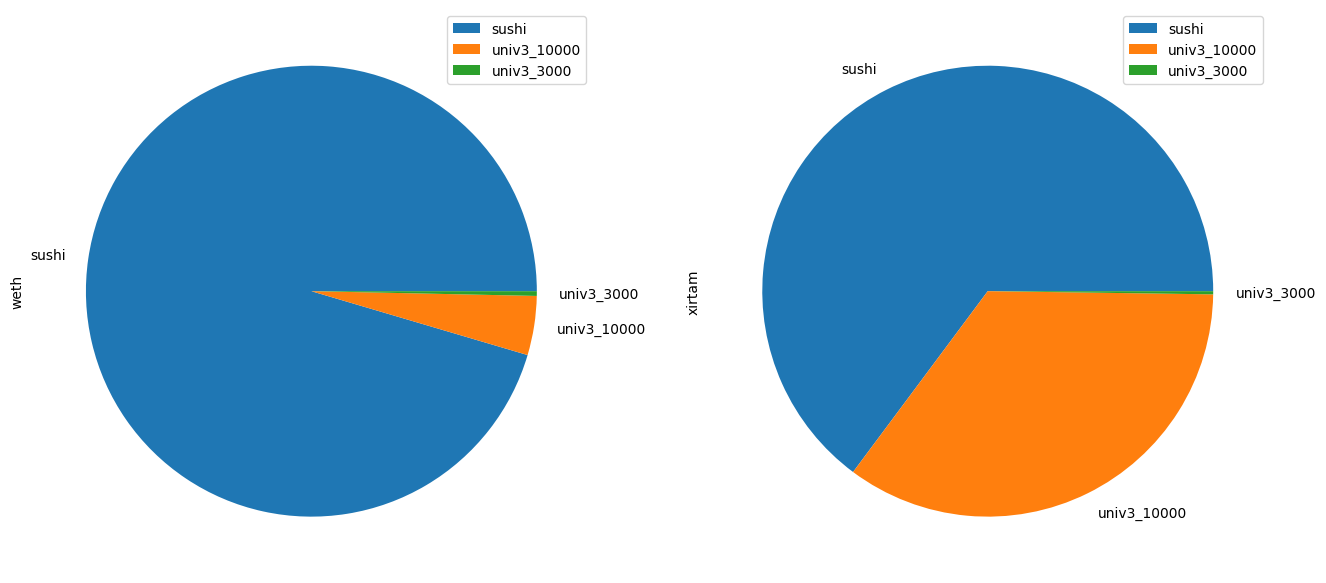

In [61]:
plot = df.plot.pie(subplots=True, figsize=(16, 8))